# Federico Campanozzi - Progetto Data Intensive con Relazione
                                                                                                             a.a. 2021/2022

## 1 - Descrizione del problema

L'obiettivo del progetto è quello di creare un modello predittivo che, data una transazione, determini se è lecita oppure no. Abbiamo a disposizione un enorme dataset con circa $\approx\,6\,\cdot\,10^6$ record. 

Il modello da creare sarà quindi un modello di classificazione binario, cioè con sole due classi 1 se è una transazione illecita e 0 altrimenti.

### 1.1 - Descrizione del Dataset

Le colonne del dataset sono così definite : 
- step: rappresenta un'unita di tempo 1 = 1 ora.
- type: tipo di transazione.
- amount: quanto denaro sto spostando.
- nameOrig: codice cliente di chi fa lo spostamento.
- oldbalanceOrg: soldi nel conto corrente del mittente.
- newbalanceOrig: soldi nel conto corrente del mittente, dopo la transazione.
- nameDest: codice cliente del beneficiario.
- oldbalanceDest: soldi nel conto corrente del destinatario.
- newbalanceDest: soldi nel conto corrente del destinatario, dopo la transazione.
- isFraud: 1 se la transazione è stato etichettata come illecita 0 altrimenti.
- isFlaggedFraud : il risultato del modello predittivo.

## 2- Analisi esplorativa

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Partiamo con l'importare il dataset in un DataFrame pandas.

In [4]:
transactions = pd.read_csv("../data/data.csv")
print(f"Dimensioni del dataset : {transactions.values.shape}")
transactions.drop(columns=["isFlaggedFraud"])[:10]

Dimensioni del dataset : (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0


Estraiamo, con il metodo *describe*, dal DataFrame tutte le statistiche utili al fine di capire le feature che possiamo usare e le feature che è meglio "accantonare". Ho usato il parametro *include='all'* poichè nel dataset ci sono variabili categoriche (i.e. nameDest) e quindi pandas può non restituire alcune righe (i.e. unique, top e altre) che invece mi interessa sapere. *include='all'* permette appunto di includere i valori mancanti (NaN).

In [5]:
transactions.drop(columns=["isFlaggedFraud"]).describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00


Determiniamo, grazie al metodo *corr*, la matrice di correlazione per capire quali feature sono maggiormente correlate ad altre. A titolo di esempio usiamo la correlazione di pearson.

In [6]:
transactions.drop(columns=["isFlaggedFraud"]).corr(method='pearson')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


Possiamo notare che le feature maggiorment correlate sono :

In [7]:
feature_list = ["type","amount","oldbalanceOrg","newbalanceOrig"]

purtroppo il metodo *corr* non supporta nativamente il calcolo della correlazione per le variabili categoriche, quindi ho aggiunto alla *feature_list* anche la variabile categorica "type". 

Le variabili categoriche *nameOrig* e *nameDest* sono state scartate perchè altamente variabili e non continue, quindi non direttamente utilizzabili. Ho escluso la variabile *step* perchè difficilmente utilizzabile sia come var. categorica sia come var. numerica.

In generale è sempre possibile utilizzare le variabili costruendo dei metodi "ad hoc" per raggrupparle, in questo progetto non ho trovato un metodo che facesse al caso mio.

### 2.1 - Grafici

I seguenti grafici hanno lo scopo di far capire quanto il "tipo transazione" (variabile categorica "type") è importante nel nostro studio (quindi anche il perchè è stata inclusa nella *feature_list*) e lo sbilanciamento della var. binaria da predire *isFraud*.

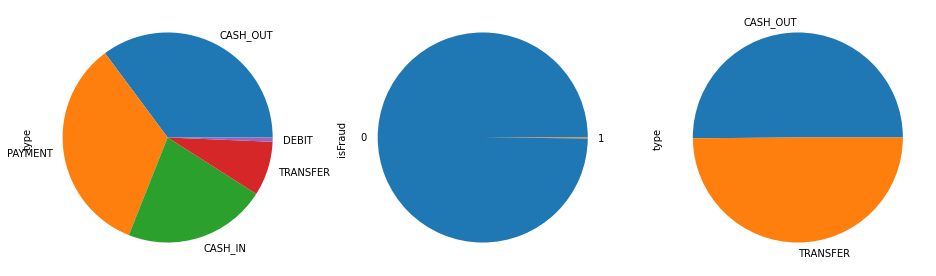

In [8]:
plt.figure(figsize=(16, 10))
transactions["type"].value_counts().plot.pie(ax=plt.subplot(1, 3, 1));
transactions["isFraud"].value_counts().plot.pie(ax=plt.subplot(1, 3, 2));
transactions[transactions["isFraud"] == 1]["type"].value_counts().plot.pie(ax=plt.subplot(1, 3,3));

Per visualizzare su un grafico a dispersione la correlazione delle feature si può procedere in diversi modi. Quello proposto in questo progetto è la creazione di n grafici che combinano 2 feature alla volta. Questo approccio può andare bene se il numero di feature è ridotto (<10) altrimenti bisogna procedere a buon senso (i.e. basandosi sulla matrice di correlazione) creando manualmente i grafici.

Per questa parte uso un dataset ridotto per limitare il tempo di calcolo dei grafici e perchè quello che vogliamo è un'indicazione qualitativa.

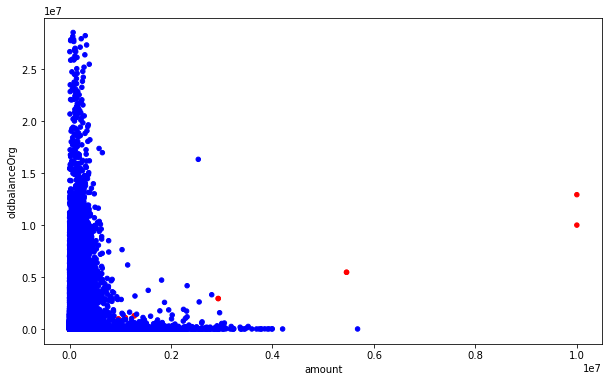

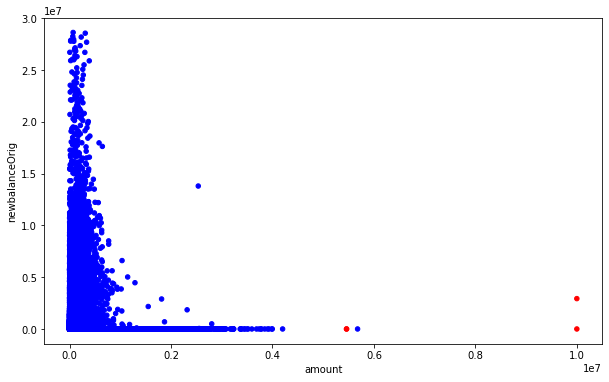

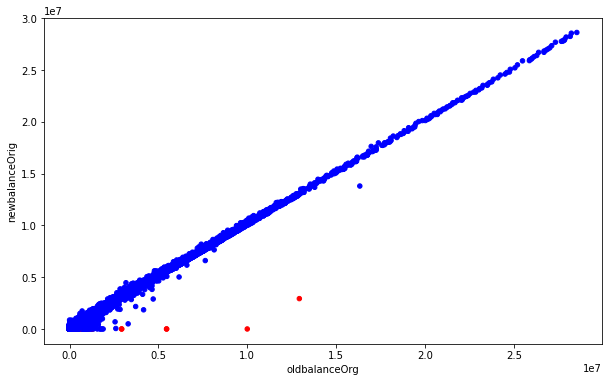

In [9]:
transactions = pd.read_csv("../data/data.csv", nrows=40_000)
tfraut_colors = transactions["isFraud"].map({0: "blue", 1: "red"})
for f_i in range(1, len(feature_list)):
     for f_j in range(f_i + 1, len(feature_list)) :        
        transactions.plot.scatter(feature_list[f_i], feature_list[f_j], c=tfraut_colors, figsize=(10, 6));

## 3 - Normalizzazione dei dati

Iniziamo col dividere le feature in due gruppi (perchè poi andranno trattate diversamente):
   - Feature Numeriche : Applicheremo una **normalizzazione** per avere la stessa scala.
   - Feature Categoriche : Applicheremo una **binarizzazione** che sotituisce ogni singola colonna categorica con n colonne binarie, dove n indica il numero distinto di valori. In questo dataset, come anche anticipato nel punto 1, l'unica var. facilmente utilizzabile è "type" che produrrà 5 var. binarie.

In [10]:
feature_numeric = ["amount","oldbalanceOrg","newbalanceOrig"]
feature_categorical = ["type"]

Grazie alla classe *ColumnTransformer* possiamo applica entrambe queste trasformazioni in modo semplice e in *Pipeline*. Memorizzo l'oggeto in una variabile così lo posso riutilizzare successivamente per la creazione dei modelli di learning.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=43)

preproc = ColumnTransformer([
    ("numeric",StandardScaler(),feature_numeric),
        ("categorical",OneHotEncoder(),feature_categorical)
    ],remainder="drop")

Vediamo, a titolo di esmpio, come cambia il daset visualizzando i primi 10 record.

In [12]:
X_sample = transactions[feature_numeric + feature_categorical]
preproc.fit_transform(X_sample)
f_names = feature_numeric + list(preproc.named_transformers_["categorical"].get_feature_names())
pd.DataFrame(
    preproc.transform(X_sample),
    columns = f_names
).head(10)

,amount,oldbalanceOrg,newbalanceOrig,x0_CASH_IN,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER
0,-0.439241,-0.266896,-0.273043,0.0,0.0,0.0,1.0,0.0
1,-0.464742,-0.331287,-0.333001,0.0,0.0,0.0,1.0,0.0
2,-0.470125,-0.340399,-0.341250,0.0,0.0,0.0,0.0,1.0
3,-0.470125,-0.340399,-0.341250,0.0,1.0,0.0,0.0,0.0
4,-0.433394,-0.322506,-0.328533,0.0,0.0,0.0,1.0,0.0
5,-0.445706,-0.317184,-0.321659,0.0,0.0,0.0,1.0,0.0
6,-0.447976,-0.261248,-0.266324,0.0,0.0,0.0,1.0,0.0
7,-0.445566,-0.264322,-0.269670,0.0,0.0,0.0,1.0,0.0
8,-0.457835,-0.339322,-0.341250,0.0,0.0,0.0,1.0,0.0
9,-0.453636,-0.322434,-0.325769,0.0,0.0,1.0,0.0,0.0


### 3.1 - SVD

Per rappresentare tutte le feature in un unico grafico si può utilizzare la decomposizione **SVD** (Single Value Decomposition) che trasforma (appunto decompone) una spazio k-dimensionale in uno spazio n-dimensionale.

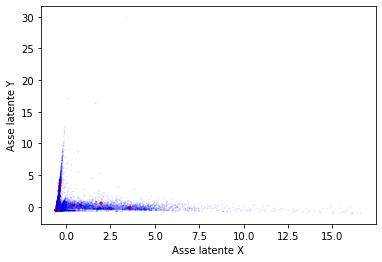

In [13]:
from sklearn.decomposition import PCA

pca = PCA()

color_map = transactions[:X_train.values.shape[0]]["isFraud"].map({0: "blue", 1: "red"})
size_map = transactions[:X_train.values.shape[0]]["isFraud"].map({0: 0.25, 1:5.0})
alpha_blend_map = transactions[:X_train.values.shape[0]]["isFraud"].map({0: 0.1, 1:1})
x_preproc = pca.fit_transform(preproc.fit_transform(X_train))

plt.scatter(x_preproc[:,0], x_preproc[:,1], c=color_map, s=size_map, alpha=alpha_blend_map)
plt.xlabel('Asse latente X')
plt.ylabel('Asse latente Y')
plt.show()

## 4 - Modelli di Learning

Data il grande numero di istanze di questo dataset per contenere drasticamente i tempi di calcolo (vista la natura di questo progetto) limitiamo il dataset a $10^5$ istanze

In [14]:
from sklearn.pipeline import Pipeline

transactions = pd.read_csv("../data/data.csv", nrows=100_000)
classes = ["isFraud", "Honest"]

X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=43)

Predisponiamo inoltre alcune "utility function" che migliorano la leggibilità del codice e la riusabilità.

In [72]:
# Plotting Functions
def plot_separator_on_data(X, y, model=None):
    '''plot data into 2d space'''
    c_map = transactions[:X.values.shape[0]]["isFraud"].map({0: "blue", 1: "red"})
    X = np.array(X)
    plt.figure(figsize=(8, 6));
    plt.scatter(X[:, 0], X[:, 1], c=c_map)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        sep_y = separator_2d(model, sep_x)
        plt.plot(sep_x, sep_y, c="green", linewidth=2)
        plt.xlim(xlim)
        plt.ylim(ylim)
    return None

def separator_2d(model, x1):
    '''draw a 2d line based his equation'''
    w = model.coef_[0]
    b = model.intercept_[0]
    return -x1 * w[0] / w[1] - b / w[1]

In [73]:
# Accurancy Functions
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error

def rmspe(y_real, y_pred):
    '''Root Mean Squared Percentage Error'''
    return np.sqrt(np.mean((y_pred / y_real - 1)**2))

def print_eval_regressor_tree(X, y, model, print_base=True):
    '''print eval for all regression tree model'''
    y_pred = model.predict(X)
    print(f"MSE   : {mean_squared_error(y, y_pred):12.4f}")
    #print(f"RMSPE : {rmspe(y, y_pred):12.4f}")
    if print_base : print_eval_base(X,y,model)
    return None

def print_eval_base(X, y, model, pad = 3):
    '''print eval for all model, only R^2 score '''
    print(f"R^2{''.rjust(pad, ' ')}: {model.score(X,y):12.4f}")
    return None

def print_eval_classify(X, y, model, classes, print_base=True):
    '''print eval for classification model'''
    y_pred = model.predict(X)    
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix : ")
    print_matrix(classes, cm)
    print(f"\nPRECISION  : {precision_score(y, y_pred):12.4f}")
    print(f"RECALL     : {recall_score(y, y_pred):12.4f}")
    print(f"F1-MEASURE : {f1_score(y, y_pred, average='macro'):12.4f}")
    if print_base : print_eval_base(X, y, model, 8)
    return None

def verify(value, const, delta=0):
    if (value >= const-delta and value <= const+delta):
        print("ASSERT OK")
    else:
        print("ASSERT FAIL")

In [74]:
# Others Functions
def print_matrix(classes, matrix, pad = 10):
    '''This method prints a matrix with better formatting.
    Is used for print n x n confusion matrix'''
    for i in range(len(classes)):
        if i == 0 : 
            for c in ([" "] + classes):
                print(f"{c.rjust(pad, ' ')}",end=' ')
            print()
        for j in range(len(classes)):
            if (j == 0) : 
                print(f"{classes[i].rjust(pad, ' ')}",end=' ')
            print(f"{str(matrix[i][j]).rjust(pad, ' ')}",end=' ')
        print()
    return None

Di seguito sono implementati alcuni modelli di learning con i metodi tradizionali di "shallow learning".

## 4.1 - Modelli di Regressione

I primi modelli che ho provato sono gli alberi di regressione.

Per usare questa parte bisogna aver intallato le seguenti librerie :

In [18]:
#%conda install XGBoost
#%conda install Lightgbm
#%conda install Catboost

Di seguito sono implementati i seguenti algoritmi:
   - Random Forest
   - XGBRegressor
   - LightGBM
   - Logistic Loss

### 4.1.1 - Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
    ("preproc", preproc),
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=500, 
                                                    max_samples=0.2, 
                                                    random_state=43,
                                                    max_features="sqrt"))
])
model.fit(X_train, y_train.values.ravel())
print_eval_regressor_tree(X_val, y_val.values.ravel(), model)

MSE   :       0.0006
R^2   :       0.2361


Possiamo vedere l'importanza delle feature grazie alla proprietà *feature_importances_* 

In [20]:
pd.DataFrame(model.named_steps["RandomForestRegressor"].feature_importances_,index=f_names,columns=["value"]).T

,amount,oldbalanceOrg,newbalanceOrig,x0_CASH_IN,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER
value,0.49592,0.452824,0.025989,0.001135,0.010253,0.000659,0.001086,0.012134


### 4.1.2 - XGBoost

In [71]:
from xgboost import XGBRegressor

xgbm = XGBRegressor(objective='reg:squarederror', 
                    learning_rate = 0.01577, 
                    reg_lambda=0.008, 
                    reg_alpha=0.0001, 
                    n_estimators=1025, 
                    random_state=43)
model = Pipeline([
    ("preproc", preproc),
    ("XGBRegressor", xgbm)
])
model.fit(X_train, y_train)
print_eval_regressor_tree(X_val, y_val.values.ravel(), model)
pd.DataFrame(model.named_steps["XGBRegressor"].feature_importances_,index=f_names,columns=["value"]).T

MSE   :       0.0005
R^2   :       0.3259


,amount,oldbalanceOrg,newbalanceOrig,x0_CASH_IN,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER
value,0.176989,0.122397,0.108512,0.000048,0.047564,0.000231,0.532877,0.011382


### 4.1.3 - LightGBM

In [22]:
from lightgbm import LGBMRegressor

model = Pipeline([
    ("preproc",preproc),
    ("LGBM", LGBMRegressor(n_estimators=1200, random_state=43))
])

model.fit(X_train, y_train.values.ravel())
print_eval_regressor_tree(X_val, y_val.values.ravel(), model)

MSE   :       0.0006
R^2   :       0.4526


### 4.1.4 - Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

model_lr = Pipeline([
    ("preproc", preproc),
    ("LogisticRegression", LogisticRegression(solver="saga", random_state=43, class_weight={1:45}, max_iter=100000))
])

model_lr.fit(X_train, y_train.values.ravel())

print_eval_regressor_tree(X_val, y_val.values.ravel(), model_lr, False)
print_eval_classify(X_val, y_val.values.ravel(), model_lr, classes, True)

MSE   :       0.0028
Confusion Matrix : 
              isFraud     Honest 
   isFraud      33231         69 
    Honest         24         10 

PRECISION  :       0.1266
RECALL     :       0.2941
F1-MEASURE :       0.5878
R^2        :       0.9972


Analizziamo, limitando a 2 il numero di feature, come la regressione logistica separa i dati.

MSE   :       0.0014
Confusion Matrix : 
              isFraud     Honest 
   isFraud      66566         51 
    Honest         44          6 

PRECISION  :       0.1053
RECALL     :       0.1200
F1-MEASURE :       0.5557
R^2        :       0.9986


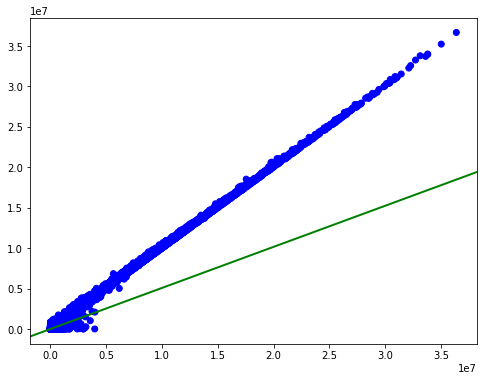

In [75]:
X_lr_2 = transactions[["oldbalanceOrg","newbalanceOrig"]]
y_lr_2 = transactions[["isFraud"]]

X_train_lr_2, X_val_lr_2, y_train_lr_2, y_val_lr_2 = train_test_split(X_lr_2, y_lr_2, test_size=1/3, random_state=43)

model_lr_2 = Pipeline([
    ("preproc", StandardScaler()),
    ("LogisticRegression", LogisticRegression(solver="saga", random_state=43, class_weight={1:45}, max_iter=100000))
])

model_lr_2.fit(X_train_lr_2, y_train_lr_2.values.ravel())

print_eval_regressor_tree(X_val_lr_2, y_val_lr_2.values.ravel(), model_lr_2, False)
print_eval_classify(X_val_lr_2, y_val_lr_2.values.ravel(), model_lr_2, classes, True)

plot_separator_on_data(X_val_lr_2, y_val_lr_2, model_lr_2.named_steps["LogisticRegression"]);

## 4.2 - Modelli di Classificazione

Vediamo se i modelli di classificazione possono dare risultati migliori dei modelli precedentemente implementati. Di seguito sono implementati i seguenti algoritmi:
- Alberi Decisionali
- XGBClassifier
- Support Vector Machine

### 4.2.1 - Alberi Decisionali

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

model_dt = Pipeline([
    ("preproc", preproc),
    ("DecisionTreeClassifier", DecisionTreeClassifier(max_depth=5,random_state=43))
])

model_dt.fit(X_train, y_train)
print_eval_classify(X_val, y_val, model_dt, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud      33298          2 
    Honest         31          3 

PRECISION  :       0.6000
RECALL     :       0.0882
F1-MEASURE :       0.5767
R^2        :       0.9990


Gli alberi decisionali funzionano tendenzialmente molto meglio di qualsiasi albero di regressione e hanno la fantastica caratteristica di essere semplici da capire (in gerco "white box") al contrario, ad esempio, di una rete neurale che si dice essere una "black box". Grazie al metodo *plot_tree* possiamo visualizzare l'albero graficamente ...

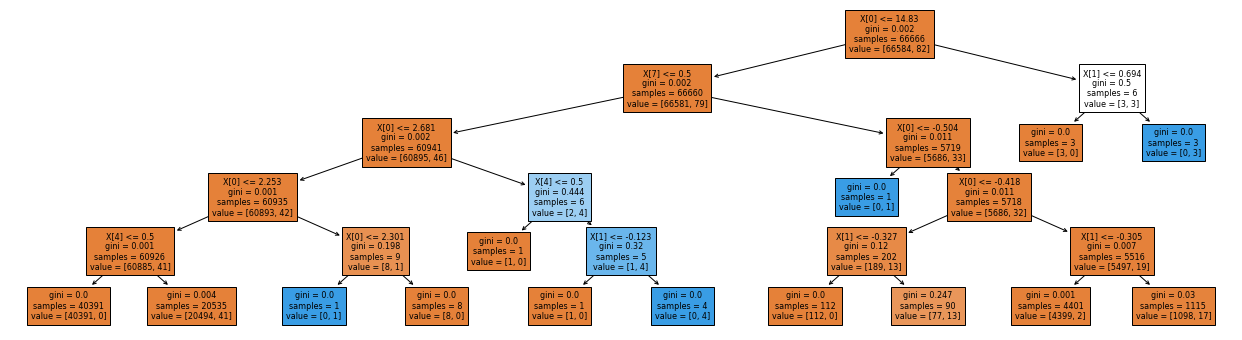

In [26]:
plt.figure(figsize=(22, 6))
plot_tree(model_dt.named_steps["DecisionTreeClassifier"], max_depth=5, filled=True, fontsize=8);

... e con il metodo *export_text* testualmente.

In [27]:
from sklearn.tree import export_text
print(export_text(model_dt.named_steps["DecisionTreeClassifier"], feature_names=f_names))

|--- amount <= 14.83
|   |--- x0_TRANSFER <= 0.50
|   |   |--- amount <= 2.68
|   |   |   |--- amount <= 2.25
|   |   |   |   |--- x0_CASH_OUT <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- x0_CASH_OUT >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- amount >  2.25
|   |   |   |   |--- amount <= 2.30
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  2.30
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  2.68
|   |   |   |--- x0_CASH_OUT <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- x0_CASH_OUT >  0.50
|   |   |   |   |--- oldbalanceOrg <= -0.12
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- oldbalanceOrg >  -0.12
|   |   |   |   |   |--- class: 1
|   |--- x0_TRANSFER >  0.50
|   |   |--- amount <= -0.50
|   |   |   |--- class: 1
|   |   |--- amount >  -0.50
|   |   |   |--- amount <= -0.42
|   |   |   |   |--- oldbalanceOrg <= -0.33
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- oldbalanceOrg >  -0.33
|   |   |   

### 4.2.2 - XGBClassifier

In [84]:
from xgboost import XGBClassifier 

model_xgb = Pipeline([
    ("preproc", preproc),
    ("XGBClassifier",
         XGBClassifier(objective='reg:squarederror', 
                        learning_rate = 0.01577, 
                        reg_lambda=0.008, 
                        reg_alpha=0.0001, 
                        n_estimators=50,
                        use_label_encoder = False, 
                        random_state=43))
])

model_xgb.fit(X_train, y_train.values.ravel())
print_eval_classify(X_val, y_val, model_xgb, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud      66609          8 
    Honest         45          5 

PRECISION  :       0.3846
RECALL     :       0.1000
F1-MEASURE :       0.5792
R^2        :       0.9992


### 4.2.3 - Support Vector Machines (SVM)

In [29]:
from sklearn.svm import SVC

model = Pipeline([
    ("preproc", preproc),
    ("SVM", SVC(random_state=43, C=0.1, degree=3, random_state=43))
])

model.fit(X_train, y_train.values.ravel())
#print_eval_classify(X_val, y_val, model, classes)
print_eval_base(X_val, y_val, model)

R^2   :       0.9990


## 4.3 - Neural Network

A scopo puramente didattico ho implementato anche una rete neurale per vedere se può risolvere anch'essa il problema di classificazione.

Prima di procedere bisogna aver installato la libreria TensorFlow.

In [27]:
#%conda install TensorFlow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dropout

X_train_nn = preproc.fit_transform(X_train)
X_val_nn = preproc.transform(X_val)

model_nn = Sequential([
    Dense(32, activation="relu", input_dim=len(f_names)),
    Dense(8, activation="relu"),
    Dense(1)
],random_state=43)
model_nn.summary()
model_nn.compile(optimizer="adam", loss="mse",  metrics=["accuracy"])
fit_history = model_nn.fit(X_train_nn, y_train, batch_size=100, epochs=10)

In [53]:
loss, acc = model_nn.evaluate(X_val_nn, y_val)
print(f"Loss (MSE) : {loss:5.4f}")
print(f"Accurancy  : {acc:5.4f}")

2084/2084 [==============================] - 2s 1ms/step - loss: 7.0438e-04 - accuracy: 0.9993
Loss (MSE) : 0.0007
Accurancy  : 0.9993


Vediamo, in due grafici separati, come varia la loss e l'accuracy in funzione dell'epoca.

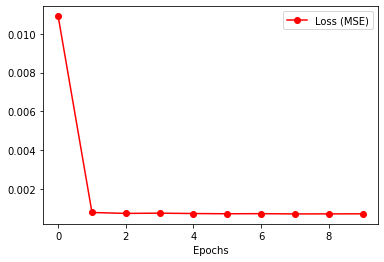

In [54]:
plt.plot(fit_history.history["loss"], "ro-")
plt.legend(["Loss (MSE)"])
plt.xlabel("Epochs");
plt.show();

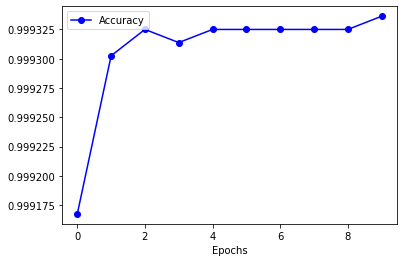

In [57]:
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Accuracy"])
plt.xlabel("Epochs");
plt.show();

Con la classe di *scikit_learn*, *KerasRegressor*, possiamo usare le potenzialità di Kerar all'interno di una *Pipeline*. Questo ci permette, con qualche accorgimento, di utilizzare *GridSearchCV* e *KFold* per fare *fine-tuning* degli iperparametri di una rete neurali (i.e numero di nodi, batch size, epoche, ecc...).

In [32]:
def build_nn(firstLayerNodes, inpDim):
    model = Sequential([
        Dense(firstLayerNodes, activation="relu", input_dim=len(f_names)),
        Dense(8, activation="relu"),
        Dense(1)
    ])
    model.summary()
    model.compile(optimizer="adam", loss="mse",  metrics=["accuracy"])
    return model

In [33]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(3, shuffle=True, random_state=42)

model = Pipeline([
    ("preproc", preproc),
    ("KerasRegressor", KerasRegressor(build_fn=build_nn,
                                      random_state=43,
                                      batch_size=100, 
                                      epochs=10,
                                      firstLayerNodes=128, 
                                      inpDim=len(f_names),
                                     )
    )
])

grid = {
    "KerasRegressor__firstLayerNodes": [8, 16, 64, 128]
}

gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train);

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


C:\Users\Federico\AppData\Local\Temp/ipykernel_6344/2291108071.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("KerasRegressor", KerasRegressor(build_fn=build_nn,


445/445 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.9923
Epoch 2/10
445/445 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9988
Epoch 3/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9989
Epoch 4/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9989
Epoch 5/10
445/445 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 0.9989
Epoch 6/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9989
Epoch 7/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9989
Epoch 8/10
445/445 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 0.9989
Epoch 9/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9989
Epoch 10/10
223/223 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9987
Model: "se

223/223 [==============================] - 0s 1ms/step - loss: 9.3613e-04 - accuracy: 0.9991
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               1152      
                                                                 
 dense_31 (Dense)            (None, 8)                 1032      
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,193
Trainable params: 2,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
445/445 [==============================] - 1s 2ms/step - loss: 0.0019 - accuracy: 0.9988
Epoch 2/10
445/445 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 0.9988
Epoch 3/10
445/445 [==

In [34]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_KerasRegressor__firstLayerNodes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,7.388350,0.685968,0.371902,0.023568,64,{'KerasRegressor__firstLayerNodes': 64},-0.001262,-0.001349,-0.000936,-0.001182,0.000178,1
1,5.417880,0.047541,0.327044,0.014063,16,{'KerasRegressor__firstLayerNodes': 16},-0.001269,-0.001358,-0.000939,-0.001188,0.000180,2
0,5.470203,0.056767,0.373262,0.011878,8,{'KerasRegressor__firstLayerNodes': 8},-0.001257,-0.001378,-0.000934,-0.001189,0.000187,3
3,10.812076,0.239913,0.368791,0.009868,128,{'KerasRegressor__firstLayerNodes': 128},-0.001336,-0.001370,-0.000940,-0.001215,0.000195,4


## 5 - Tuning degli Iperparametri

Per questa parte utilizziamo una porzione più ampia del datataset e andremo a suddividerlo in 3 parti e le useremo nel seguente modo :
   - Training Set : Per addestrare i modelli.
   - Validation Set : Per vericare l'accuratteza dei modelli su dati mai visti in fase di training.
   - Test Set : Per calcolare la confidenza.

In [30]:
from sklearn.model_selection import GridSearchCV, KFold
kf = KFold(3, shuffle=True, random_state=42)

transactions = pd.read_csv("../data/data.csv", nrows=200_000)
X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=1/3, random_state=42)

I modelli che meglio si sono comportati per risolvere questo problema sono stati i modelli di classificazione. Tra tutti i modelli implementati ottimizziamo i seguenti: 
 - Logistic Regression
 - Alberi Decisionali
 - XGBClassifier

In [31]:
grid = {
    "LogisticRegression__penalty": ['l1','l2']
}
gs = GridSearchCV(model_lr, grid, cv=kf)
gs.fit(X_train, y_train.values.ravel())
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LogisticRegression__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,6.833277,1.308793,0.012317,0.001869,l2,{'LogisticRegression__penalty': 'l2'},0.998076,0.999190,0.998785,0.998684,0.000460,1
0,45.728422,2.669660,0.011305,0.000471,l1,{'LogisticRegression__penalty': 'l1'},0.995680,0.996389,0.996929,0.996332,0.000511,2


In [76]:
grid = {
    "DecisionTreeClassifier__max_depth": [5, 10, 20, None]
}
gs = GridSearchCV(model_dt, grid, cv=kf)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_DecisionTreeClassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.099540,0.011363,0.069481,8.063099e-02,5,{'DecisionTreeClassifier__max_depth': 5},0.999393,0.999089,0.999392,0.999291,0.000143,1
1,0.110704,0.016529,0.011968,1.123916e-07,10,{'DecisionTreeClassifier__max_depth': 10},0.999224,0.999021,0.999392,0.999212,0.000152,2
2,0.112366,0.017698,0.011968,2.973602e-07,20,{'DecisionTreeClassifier__max_depth': 20},0.999224,0.999055,0.999190,0.999156,0.000073,3
3,0.112033,0.017262,0.011968,3.371748e-07,None,{'DecisionTreeClassifier__max_depth': None},0.999224,0.999055,0.999190,0.999156,0.000073,3


In [85]:
grid = [
    {
        "XGBClassifier__reg_alpha": [0.0001, 0.0005, 0.001],
    },
    {
        "XGBClassifier__reg_lambda": [0.008, 0.01]
    }
]
gs = GridSearchCV(model_xgb, grid, cv=kf)
gs.fit(X_train, y_train.values.ravel())
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_XGBClassifier__reg_alpha,param_XGBClassifier__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.391612,0.054153,0.032580,4.700217e-04,0.0001,NaN,{'XGBClassifier__reg_alpha': 0.0001},0.999325,0.999021,0.999392,0.999246,0.000161,1
1,1.393940,0.058190,0.032912,1.123916e-07,0.0005,NaN,{'XGBClassifier__reg_alpha': 0.0005},0.999325,0.999021,0.999392,0.999246,0.000161,1
2,1.388290,0.053899,0.035238,9.391466e-04,0.001,NaN,{'XGBClassifier__reg_alpha': 0.001},0.999325,0.999021,0.999392,0.999246,0.000161,1
3,1.394605,0.055286,0.031582,4.697972e-04,NaN,0.008,{'XGBClassifier__reg_lambda': 0.008},0.999325,0.999021,0.999392,0.999246,0.000161,1
4,1.390948,0.058361,0.032912,2.973602e-07,NaN,0.01,{'XGBClassifier__reg_lambda': 0.01},0.999325,0.999021,0.999392,0.999246,0.000161,1


## 6 -  Valutazione

Possiamo stimare l'accuratezza sui nuovi dati con il Processo Bernoulliano.

Per trovare $Z_{\alpha/2}$, data una certa confidenza, inizializziamo una mappa dove la chiave è la confidenza e il valore è l'area sottostante la curva di distribuzione normale standard.

In [86]:
Za2_map = {0.99:2.58, 0.98:2.33, 0.95:1.96, 0.90:1.65}

Implementiamo la funzione per il calcolo del processso Bernoulliano

In [87]:
def bernoulli_process(acc, p_value, N) :
    '''this method calculate the interval confidence based on Bernoulli Process'''
    Za2 = Za2_map[p_value]
    
    num = 2*N*acc+Za2**2
    sqrt = np.sqrt(Za2**2+4*N*acc-4*N*acc**2)
    den = 2*(N+Za2**2)
    
    return (num - Za2*sqrt) / den, (num + Za2*sqrt) / den

Nella prossima cella c'è un test-unit, in particolare si riferisce all'esempio riportato sulla slide 4 del pacco di slide "ValutazioneModelliDiClassificazione", per vedere se il metodo implementato funziona correttamente.

In [88]:
accurancy = 0.8
N = 100
confidence = 0.95
p_min, p_max = bernoulli_process(accurancy, confidence, N)
verify(p_min, 0.711, 0.01)
verify(p_max, 0.866, 0.01)
p_min, p_max, accurancy = p_min * 100, p_max * 100, accurancy * 100
print(f"L'accuratezza del modello migliore è :\n{accurancy:2.2f} % \u00B1 [{p_min:2.2f} %, {p_max:2.2f} %]")

ASSERT OK
ASSERT OK
L'accuratezza del modello migliore è :
80.00 % ± [71.12 %, 86.66 %]


Utilizziamo il metodo sopra implementato, e verificato, per calcolare l'intervallo di accuratezza del modello migliore data una confidenza del 95%.

In [89]:
accurancy = gs.best_estimator_.score(X_test, y_test)
N = X_test.shape[0]
confidence = 0.95
p_min, p_max = bernoulli_process(accurancy, confidence, N)
p_min, p_max, accurancy = p_min * 100, p_max * 100, accurancy * 100
print(f"L'accuratezza del modello migliore è :\n{accurancy:2.2f} % \u00B1 [{p_min:2.2f} %, {p_max:2.2f} %]")

L'accuratezza del modello migliore è :
99.91 % ± [99.88 %, 99.94 %]


## 8 - Resources
Link al dataset di kaggle : https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset